In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from qkeras import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns

2022-11-16 19:06:38.121039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 19:06:38.279813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 19:06:38.279912: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-16 19:06:38.303675: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 19:06:38.944598: W tensorflow/stream_executor/platform/de

In [2]:
train_df = pd.read_csv('train_1Dx.csv',nrows=1000000)
test_df = pd.read_csv('test_1Dx.csv',nrows=500000)

In [3]:
X_train = train_df.drop(columns=['x-midplane','cotAlpha']).values
X_test = test_df.drop(columns=['x-midplane','cotAlpha']).values

y_train = train_df['x-midplane'].values
y_test = test_df['x-midplane'].values

In [4]:
# scale so that it is between 0 and 1
def scale(X):
    width = np.max(X) - np.min(X)
    return ( X-np.min(X) ) / width

In [5]:
X_train = scale(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scale(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [6]:
def custom_loss(y, p):
    
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = 0.1+tf.math.softplus(tf.gather(params=p, indices=[1], axis=1))
        
    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma))
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [7]:
def CreateQModel(shape):
    x = x_in = Input(shape)
    #x = BatchNormalization()(x)
    x = QDense(64, 
               kernel_quantizer=quantized_bits(bits=5,
                                               integer=2, # look at the full precision model, input only quantized
                                               keep_negative=True,
                                               alpha=1
                                              ),
               bias_quantizer=quantized_bits(bits=5,
                                             integer=2, # look at the full precision model, input only quantized
                                             keep_negative=True,
                                             alpha=1
                                            ),
               name="dense1")(x)
    x = QActivation("quantized_relu(10,2)", name="relu1")(x)
    x = BatchNormalization()(x)
    x = QDense(2, 
               kernel_quantizer=quantized_bits(bits=5,
                                               integer=3, # look at the full precision model, input only quantized
                                               keep_negative=True,
                                               alpha=1
                                              ),
               bias_quantizer=quantized_bits(bits=5,
                                             integer=3, # look at the full precision model, input only quantized
                                             keep_negative=True,
                                             alpha=1
                                            ),
               name="dense2")(x)
    
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateQModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=custom_loss)

model.summary()

2022-11-16 19:06:42.816405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 19:06:42.816822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 19:06:42.816905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-16 19:06:42.816965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-16 19:06:42.817024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense1 (QDense)             (None, 64)                1408      
                                                                 
 relu1 (QActivation)         (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (QDense)             (None, 2)                 130       
                                                                 
Total params: 1,794
Trainable params: 1,666
Non-trainable params: 128
_________________________________________________________

/home/jennetd/.local/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [8]:
es = EarlyStopping(patience=10)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=400, 
                    batch_size=4096,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/400
196/196 [==============================] - 3s 8ms/step - loss: 19.1642 - val_loss: 19.7094
Epoch 2/400
196/196 [==============================] - 1s 7ms/step - loss: 18.7683 - val_loss: 19.3689
Epoch 3/400
196/196 [==============================] - 1s 7ms/step - loss: 18.2650 - val_loss: 18.5978
Epoch 4/400
196/196 [==============================] - 1s 7ms/step - loss: 17.8347 - val_loss: 17.9804
Epoch 5/400
196/196 [==============================] - 1s 7ms/step - loss: 17.2776 - val_loss: 18.0305
Epoch 6/400
196/196 [==============================] - 1s 7ms/step - loss: 16.6920 - val_loss: 17.6683
Epoch 7/400
196/196 [==============================] - 2s 8ms/step - loss: 15.9527 - val_loss: 15.7837
Epoch 8/400
196/196 [==============================] - 1s 7ms/step - loss: 15.2330 - val_loss: 13.6394
Epoch 9/400
196/196 [==============================] - 1s 7ms/step - loss: 14.6704 - val_loss: 14.5616
Epoch 10/400
196/196 [==============================] - 1s 7ms/step - los

/tmp/ipykernel_25734/3321773974.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


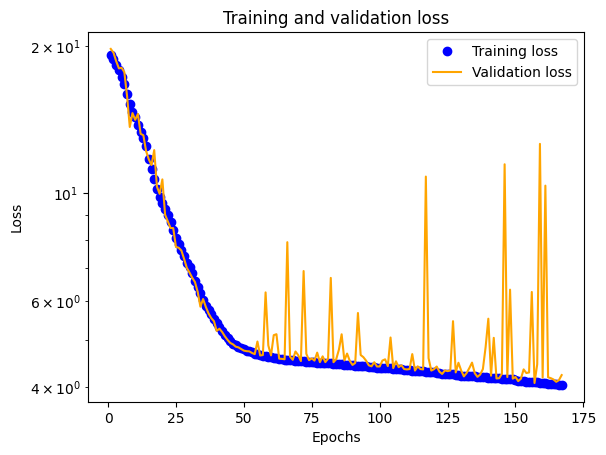

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
plt.show()

In [10]:
model.save('models_1Dx/gauss5bit.keras')

In [11]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma'])
df['sigma'] = 0.1 + tf.math.softplus(df['sigma'])
df['xtrue'] = y_test
df.to_csv("test_1DxGauss5bit.csv",header=False,index=False)

15625/15625 [==============================] - 14s 853us/step


In [12]:
residuals = y_test - p_test[:,0]
print(np.mean(residuals),np.std(residuals))

8.798731292799495 18.442530824171595


In [13]:
uncertainty= 0.1 + tf.math.softplus(p_test[:,1])
print(np.mean(uncertainty),np.std(uncertainty))

17.524214 8.283829


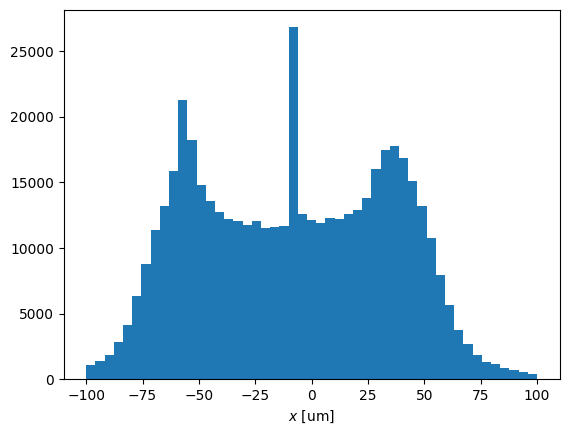

In [14]:
plt.hist(p_test[:,0],bins=np.linspace(-100,100,50))
#plt.yscale('Log')
plt.xlabel(r'$x$ [um]')
plt.show()

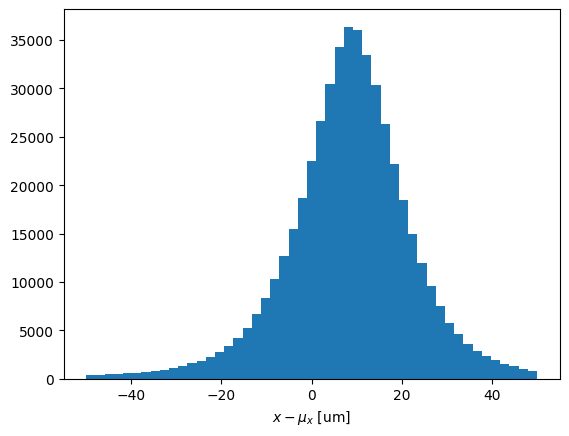

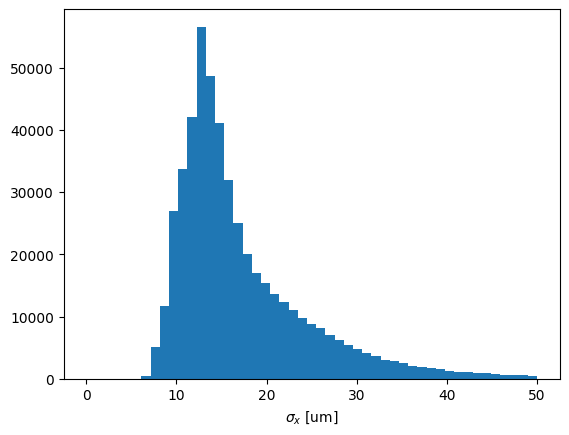

In [15]:
plt.hist(residuals,bins=np.linspace(-50,50,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')
plt.show()

plt.hist(uncertainty,bins=np.linspace(0,50,50));
#plt.yscale('Log')
plt.xlabel(r'$\sigma_x$ [um]')
plt.show()

Text(0, 0.5, '$x-\\mu_x$ [um]')

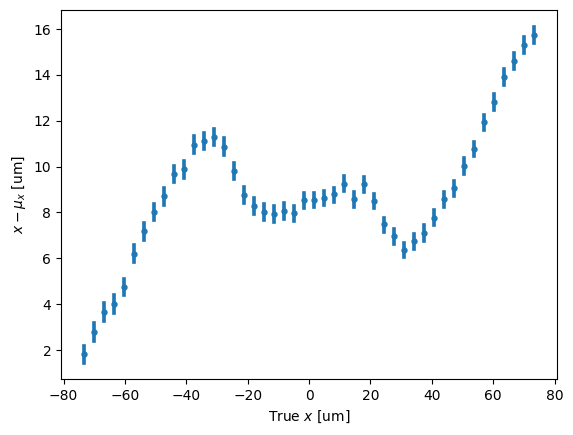

In [16]:
x = sns.regplot(x=df['xtrue'], y=df['xtrue']-df['mu'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')

Text(0, 0.5, '$\\sigma_x$ [um]')

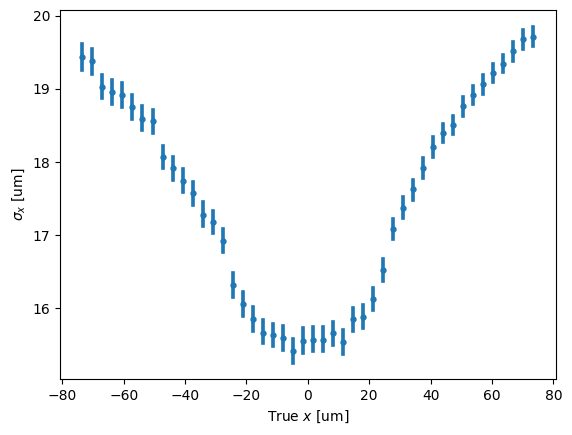

In [17]:
x = sns.regplot(x=df['xtrue'], y=df['sigma'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$\sigma_x$ [um]')

In [18]:
pulls = residuals/p_test[:,1]

Text(0.5, 0, 'pull')

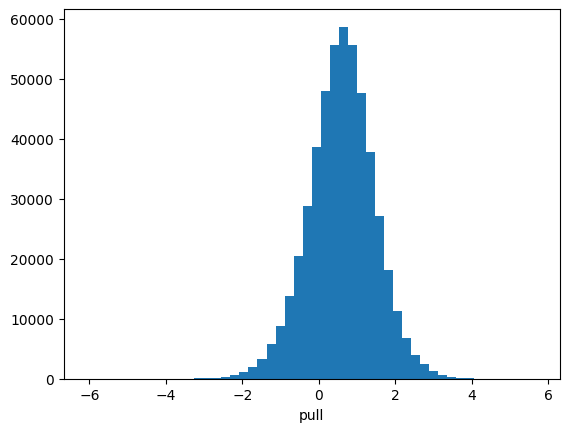

In [19]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [20]:
print(np.mean(pulls),np.std(pulls))

0.5906541186209026 0.8558360151329395


In [21]:
max(np.array(model.layers[1].get_weights()).flatten()[0].flatten())

/tmp/ipykernel_25734/2940326780.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  max(np.array(model.layers[1].get_weights()).flatten()[0].flatten())


1.9629321

In [22]:
np.max(np.array(model.layers[3].get_weights()).flatten())

2.8834953